# CIFAR-100 Image Classification

------------------

## 1. Intro

This notebook aims to compare the performance of a fully trained ResNet-18 model with unfrozen all layers with a custom convolutional neural network (CNN) on the CIFAR-100 dataset. The comparison focuses on evaluating model accuracy, training efficiency, and generalization capabilities.

We will train both models on CIFAR-100, analyzing their performance through metrics such as training/validation loss and accuracy, and discuss the advantages.


------------------

## 2. Environment configuration

In [12]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import models, transforms, datasets
import matplotlib.pyplot as plt
import numpy as np
import pickle
from src.custom_model import Conv

torch.manual_seed(42)
np.random.seed(42)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


## 3. Model architectures

In [13]:
# Custom model
custom_model = Conv().to(device)

# ResNet-18
resnet = models.resnet18()
resnet.fc = nn.Sequential(nn.Linear(resnet.fc.in_features, 100))
resnet = resnet.to(device)

**Custom model**      
![Custom_model_architecure](./img/custom_model_architecture.png)


**ResNet-18**     
![Resnet_model_architecture](./img/resnet18_architecture.png)

## 4. Data Preparation

Files already downloaded and verified


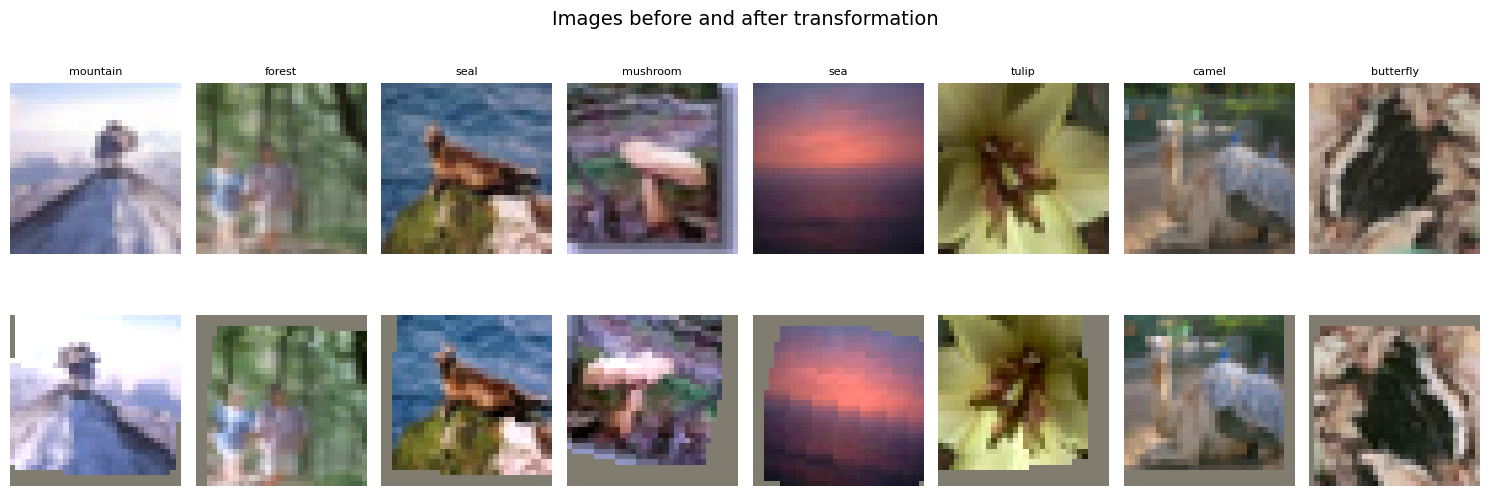

In [14]:
from src.backbone_dataloader import testloader as resnet_test_loader, trainloader as resnet_train_loader
from src.custom_dataloader import testloader as custom_test_loader, trainloader as custom_train_loader
from src.custom_dataloader import data_transforms

with open('data/cifar-100-python/meta', 'rb') as f:
    cifar100_meta = pickle.load(f)

class_names = cifar100_meta['fine_label_names']

def denormalize(tensor):
    mean = torch.tensor([0.507, 0.487, 0.441]).view(3, 1, 1).to(tensor.device)
    std = torch.tensor([0.267, 0.256, 0.276]).view(3, 1, 1).to(tensor.device)
    return tensor * std + mean

raw_dataset = datasets.CIFAR100(root='./data', train=False, download=True, transform=None)
fig, axs = plt.subplots(2, 8, figsize=(15, 6))
plt.suptitle('Images before and after transformation', fontsize=14, y=0.93)

for i in range(8):
    orig_pil = raw_dataset[i][0]
    label = class_names[raw_dataset[i][1]]

    aug_pil = data_transforms['train'](orig_pil)

    orig_tensor = transforms.ToTensor()(orig_pil)
    orig_img = orig_tensor.cpu().numpy().transpose(1, 2, 0)

    aug_img = denormalize(aug_pil).cpu().numpy().transpose(1, 2, 0)

    axs[0, i].imshow(orig_img.clip(0, 1))
    axs[0, i].set_title(label, fontsize=8)
    axs[0, i].axis('off')

    axs[1, i].imshow(aug_img.clip(0, 1))
    axs[1, i].axis('off')

plt.tight_layout()
plt.show()

## 5. Loss Function Graphs During Training

<div style="display: flex; justify-content: center; align-items: flex-start;">
  <div style="margin: 0 10px; text-align: center;">
    <strong>Custom model</strong><br>
    <img src="./img/custom_model_loss_function.png" alt="Custom_graph" style="max-width: 100%;">
  </div>
  <div style="margin: 0 10px; text-align: center;">
    <strong>Resnet18</strong><br>
    <img src="./img/resnet18_loss_function.png" alt="Resnet" style="max-width: 100%;">
  </div>
</div>


## 6. Models accuracy

In [15]:
def eval(
    model: torch.nn.Module,
    loader: torch.utils.data.DataLoader,
    device: torch.device,
    model_path: str,
):
    model.load_state_dict(torch.load(model_path))
    model.to(device)
    model.eval()
    all_predict = []
    all_labels = []

    with torch.no_grad():
        for images, labels in loader:
            images = images.to(device)
            labels = labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            all_predict.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    return all_labels, all_predict

custom_labels, custom_predict = eval(custom_model, custom_test_loader, device, 'models/custom_model.pth')
resnet_labels, resnet_predict = eval(resnet, resnet_test_loader, device, 'models/resnet18.pth')


/tmp/ipykernel_540659/3561086459.py:7: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_path))


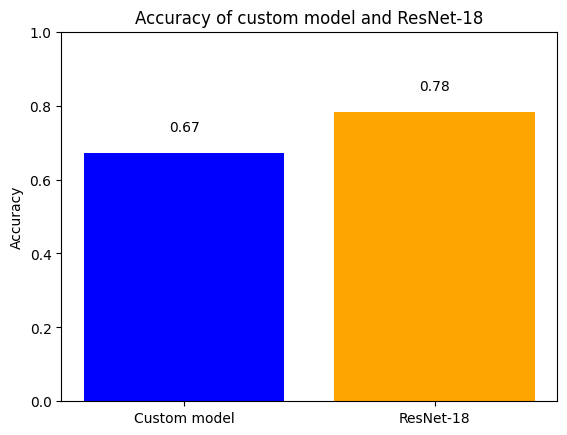

In [16]:
custom_accuracy = np.mean(np.array(custom_labels) == np.array(custom_predict))
resnet_accuracy = np.mean(np.array(resnet_labels) == np.array(resnet_predict))

fig, ax = plt.subplots()
bar_colors = ['blue', 'orange']
ax.bar(['Custom model', 'ResNet-18'], [custom_accuracy, resnet_accuracy], color=bar_colors)
for i, v in enumerate([custom_accuracy, resnet_accuracy]):
    ax.text(i, v + 0.05, f'{v:.2f}', ha='center', va='bottom')
ax.set_ylabel('Accuracy')
ax.set_ylim(0, 1)
plt.title('Accuracy of custom model and ResNet-18')
plt.show()

## 7. Accuracy by class

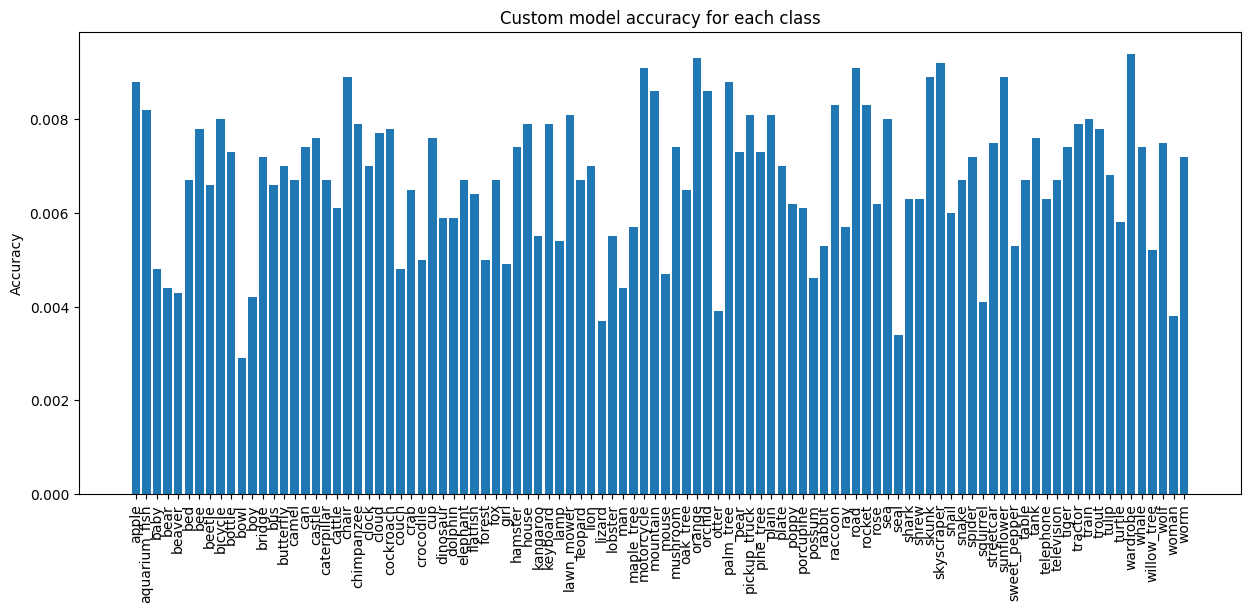

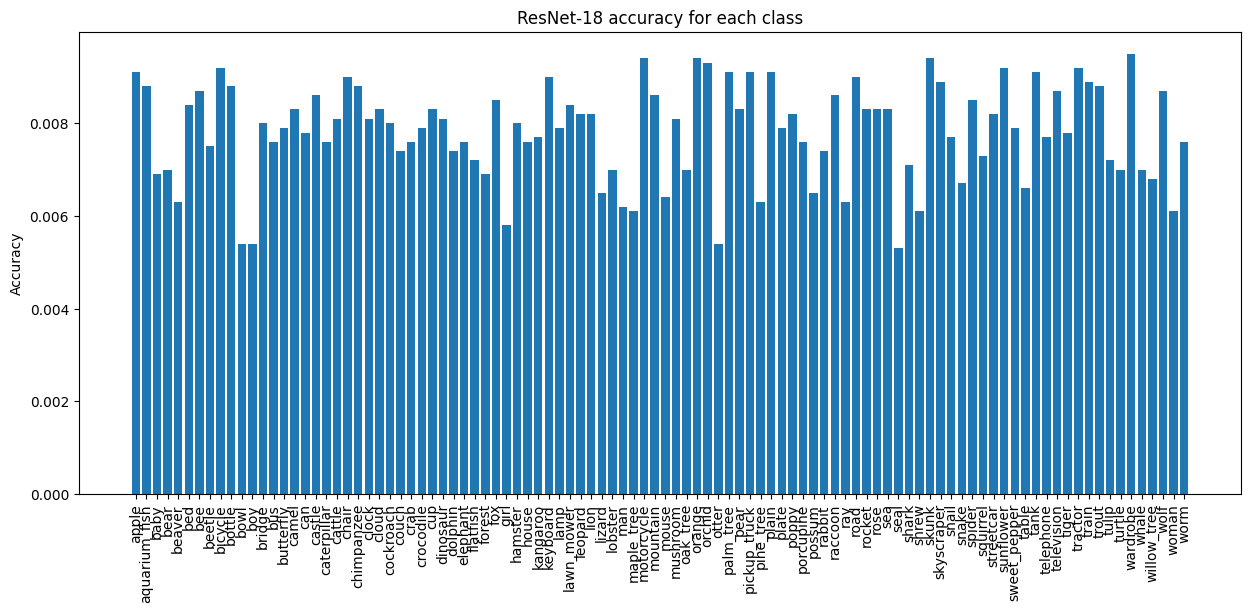

In [17]:
def plot_every_class_accuracy(labels, predict, class_names, title):
    class_correct = []
    for i in range(100):
        correct = (np.array(labels) == np.array(predict)) & (np.array(labels) == i)
        class_correct.append(correct.mean())

    plt.figure(figsize=(15, 6))
    plt.bar(class_names, class_correct)
    plt.xticks(range(100), class_names, rotation=90)
    plt.title(title)
    plt.ylabel('Accuracy')
    plt.show()

plot_every_class_accuracy(custom_labels, custom_predict, class_names, 'Custom model accuracy for each class')
plot_every_class_accuracy(resnet_labels, resnet_predict, class_names, 'ResNet-18 accuracy for each class')

## 8. Final thoughts

## Accuracy & Generalization
The custom CNN reaches an accuracy of roughly **67%**, whereas the ResNet-18 model achieves about **78%**. In essence, ResNet-18 generalizes better, with training and validation losses that remain close throughout the process.

## Training Dynamics

### Custom CNN Insights
- **Learning Behavior:**  
  The model shows a steady decline in training loss over time. However, as epochs progress, the widening gap between training and validation loss hints at potential overfitting.
- **Stabilization:**  
  Beyond approximately twenty to thirty epochs, the validation performance begins to level off, signaling that the network’s capacity for further improvement is limited.

### ResNet-18 Insights
- **Learning Behavior:**  
  Both training and validation losses decrease smoothly, with the gap between them remaining narrow—a sign of stronger generalization.
- **Initial Phase:**  
  A brief period of overfitting appears during the first few epochs, but reducing the learning rate helped to get to the optimum.
- **Rapid Convergence:**  
  The model settles into a low-loss state faster, demonstrating a more efficient learning process.

## Class-specific Observations
- **Distinct Classes:**  
  Categories with clear, unique features perform exceptionally well, often scoring in the upper eighties to low nineties.
- **Similar Classes:**  
  Those with overlapping visual characteristics tend to achieve moderate accuracy, usually in the mid-sixties to low seventies.
- **Overall Trend:**  
  ResNet-18 generally outperforms the custom CNN by a margin of around ten to fifteen percentage points across the board.

## Computational Considerations

### Custom CNN
- **Speed:**  
  Each epoch runs relatively quickly, taking somewhere about one minute on rtx 3050 mobile.
- **Efficiency:**  
  Its lightweight architecture minimizes memory usage, though this simplicity restricts its ability to capture more complex patterns.

### ResNet-18
- **Speed:**  
  Training an epoch is slower, taking somewhere about one minute thirty seconds on the same device.
- **Complexity:**  
  Despite requiring more computational resources, its deeper, residual architecture enables it to learn more intricate features, leading to better overall performance.

## Final Thoughts
When computational resources are ample, ResNet-18 is clearly the superior option due to its higher accuracy and better generalization. Conversely, if speed and lower resource consumption are critical, the custom CNN might still be a suitable, albeit less precise, alternative.

